╔══<i><b>Public-AI</b></i>═══════════════════════════════════════════════════╗
### ✎&nbsp;&nbsp;week 2. 협업 필터링
# Section 2. 협업 필터링 알고리즘의 종류 및 구현

협업 필터링에는 유저 기반 협업 필터링과 아이템 기반 협업 필터링이 있습니다. 두 가지 종류의 협업 필터링 알고리즘을 배우면서 협업 필터링을 보다 깊이 이해해보겠습니다. 그 다음에는 앞서 샘플 리뷰 데이터로 배운 유사도 계산을 보다 큰 데이터셋에 적용해 아이템 기반 협업 필터링을 직접 구현해보겠습니다.

### _Objective_ 

* [ **협업필터링 알고리즘의 종류**] 협업 필터링의 핵심 알고리즘, 유저 기반 협업 필터링과 아이템 기반 협업 필터링의 개념을 배웁니다.
* [ **구현** ] Movie-lens 데이터를 이용해 아이템 기반 협업 필터링을 구현해봅니다.
<br>

╚═══════════════════════════════════════════════════════════╝

In [1]:
# 필요한 라이브러리 가져오기
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
np.set_printoptions(3)

#### 데이터 가져오기

이번 시간 동안 Pandas로 연산을 진행하기 위해서, 미리 CSV파일로 만들어진 데이터들을 직접 부르도록 하겠습니다.

In [2]:
# 데이터를 다운받은 후, 로컬 컴퓨터에 저장합니다.
# 한번 다운받은 후에는 다운받은 데이터로 바로 불러오게 됩니다.
movie_path = get_file("movies.csv",
                      "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/datasets/movies.csv")
movie_df = pd.read_csv(movie_path)

genre_path = get_file("genres.csv",
                      "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/datasets/genres.csv")
genre_df = pd.read_csv(genre_path)

rating_path = get_file("ratings.csv",
    "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/datasets/ratings.csv")
rating_df = pd.read_csv(rating_path)
rating_df.drop(columns='rated_at',inplace=True)

# 메모리 문제를 좀 더 완화하기 위해 8비트로 변경(0~255)
rating_df.rating = (rating_df.rating*2).astype(np.uint8)
rating_df.movie_id = rating_df.movie_id.astype(np.uint32)
rating_df.user_id = rating_df.user_id.astype(np.uint32)

# \[ 협업 필터링 알고리즘의 종류: 유저 기반 협업 필터링과 아이템 기반 협업 필터링 \]
---


## 1. User-Based Collaborative Filtering 과 Item-Based Collaborative Filtering

![Imgur](https://i.imgur.com/JRe39qe.png)

협업 필터링(Collaborative Filtering)을 통해 추천하는 방법은 크게 2가지가 있습니다. 

* 유저 기반 협업 필터링(User-Based Collaborative Filtering) : 유저와 비슷한 유저가 좋게 평가한 영화를 추천
* 아이템 기반 협업 필터링(Item-Based Collaborative Filtering) : 유저가 좋아하는 영화와 비슷한 영화를 추천

두 알고리즘의 중요한 차이는 바로 <무엇에 대한 유사도>를 계산하느냐에 있습니다. 유저 기반 협업 필터링은 유저 간의 유사도를 계산하여 추천하는 방식이고, 아이템 기반 협업 필터링은 아이템 간의 유사도를 계산하는 방식입니다. 즉, 앞서 Section 1에서 배운 유사도를 이용하여 유저 간의 유사도를 계산할 것인지, 제품 간의 유사도를 계산할 것인지에 따른 차이가 있는 것이죠. 

## 2. User Similarity Matrix

Section 1에서는 유저 5명을 놓고 유사도를 계산해보았는데, 실제 시스템에는 훨씬 많은 유저가 있습니다. 유저 간의 유사도 행렬(User Similarity Matrix)이란 아래와 같이 각 유저 간의 영화 평점을 가지고 유사도 점수를 계산해 넣은 행렬입니다.이전 시간에 했던 유사도 계산이 사실상 위의 행렬 내 값들을 찾는 것과 동일합니다.
![Imgur](https://i.imgur.com/GNPZj56.png)

## 3. Item Similarity Matrix
아이템 간의 유사도 행렬(Item Similarity Matrix)이란 역으로 각 영화 별 유저들의 레이팅에 대한 비교로 유사도 점수를 계산해 넣어 만든 행럴입니다. 아마존에서 사용하고 있는 추천시스템이 바로 이러한 아이템 유사도 행렬을 사용하여 **아이템 기반 협업 필터링(Item-Based Collaborative Filtering) 추천 시스템**입니다. 주기적으로 아이템 유사도 행렬을 계산해주기만 하면, 운영 환경에서는 계산된 유사도 행렬에 따라 제품을 추천하면 되기 때문에 서버의 연산량 이슈가 크게 발생하지 않는 효율적인 추천 시스템입니다. 이번 시간에는 아래의 아이템 기반 협업필터링(Item-Based Collaborative Filtering)을 중심으로 구현해보도록 하겠습니다.

![Imgur](https://i.imgur.com/UaOmANU.png)

# \[ 구현 \]
---

Movie-lens 데이터를 이용해 아이템 기반 협업 필터링을 구현해보겠습니다. 보다 구체적으로는 전체 데이터를 사용할 경우 데이터가 보이는 희소성 문제를 살펴본 후, 이 문제점을 해결하기 위해 기준을 세워 협업 필터링 시스템에서 사용할 아이템과 유저 데이터를 걸러내겠습니다. 그 다음에 지난 section에서 배운 유사도 알고리즘으로 유저도 행렬을 만들어보겠습니다. 끝으로는 유사도 행렬을 이용해 영화를 추천해보겠습니다.

## 1. 데이터 속 문제 - 데이터의 Sparsity

효과적인 추천시스템을 만들기 위해 가지고 있는 모든 데이터를 써야할 것 같지만, 사실 가지고 있는 모든 데이터를 사용하게 되면 다양한 문제가 생깁니다. 데이터의 희소성(sparsity) 문제는 그 중 하나입니다. 데이터가 희소(Sparse)하다는 의미는 유저 수와 영화 수는 많은 데 비해서 유저와 아이템 사이의 상호작용 데이터는 극히 드물다는 것을 의미합니다. 온라인 쇼핑몰의 경우에 적용해서 생각해볼까요? 한 유저가 쇼핑몰에 있는 모든 상품을 주문하는 것이 아니기 때문에 유저와 상호작용이 발생한 상품은 전체에서 극히 일부일 것입니다. <br>
지금 다루고 있는 영화 리뷰 데이터에서도 마찬가지입니다. 한 유저가 평점을 남기는 영화는 전체 영화 중에 극히 일부일 것입니다. Movie-lens 데이터의 희소성은 어느 정도인지 알아봅시다.

In [3]:
num_user = len(rating_df.user_id.unique())
print(f"총 유저의 수 : {num_user}")

num_item = len(rating_df.movie_id.unique())
print(f"총 아이템의 수 : {num_item}")

ui_matrix_size = num_user * num_item
print(f"유저/아이템 행렬의 크기 : ", ui_matrix_size)

num_rating  = len(rating_df)
print(f"평점 데이터의 갯수 : ", num_rating)

print(f"Matrix 중 값이 있는 비율(Density) : {num_rating/ui_matrix_size:.3%}")

총 유저의 수 : 138493
총 아이템의 수 : 26744
유저/아이템 행렬의 크기 :  3703856792
평점 데이터의 갯수 :  20000263
Matrix 중 값이 있는 비율(Density) : 0.540%


유저와 영화 정보를 가지고 유저-아이템 행렬(User-Item Matrix)를 만들면 30억개의 칸이 있는 행렬이 만들어지지만, 이 행렬을 채우는 평점 데이터는 2천만개 정도로, 전체의 0.5% 정도만 채워집니다.

## 2. 영화 최소 기준 선정하기

전체 리뷰 데이터를 이용해 만든 유저-아이템 행렬은 밀집도(Density)가 매우 낮습니다. 평가를 한 횟수가 매우 적은 사람이나 받은 평점이 매우 적은 영화의 경우에는 유저나 영화 간 유사도가 지나치게 높게 나오거나, 적게 나올 우려도 있습니다. 
<br>
이를 방지하기 위해 적게 별점을 남긴 사람과 별점을 적게 받은 영화의 케이스를 제거해야 합니다. 어떤 기준으로 제거하는 것이 좋을까요? <br>
단순히 직관적으로 "10개 미만의 별점을 받은 영화는 지운다"고 정할 수도 있겠지만, 너무 많은 영화가 사라지면 좋은 추천 시스템을 만들기 어려워질 것입니다.<br>
따라서 정보의 손실을 최소화하면서 동시에 데이터의 희소성은 최대한 줄일 수 있는 기준을 찾아야 합니다. <br>
<br>
별점 수가 많은 순서대로 영화를 정렬하여 별점 수의 누적합 변화가 적어지는 지점을 기준으로 영화를 제거하면, 별점 정보의 손실은 최소화 하면서 데이터의 희소성 문제는 최대한 줄일 수 있을 것입니다. 영화별 별점 수의 누적합을 구하기 위해 먼저 영화별 평점 갯수를 구해봅시다.<br>

In [4]:
# movieId 별 rating의 개수를 계산하고, 크기순 정렬
count_per_movie = (
    rating_df  # 별점 테이블에서
    .movie_id  # 영화 아이디가 
    .value_counts()  # 각각 몇번씩 있었는지 계산하고,
    .sort_values(ascending=False)) # 이를 내림차순으로 정렬하세요
count_per_movie

296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
97761         1
111785        1
127875        1
114170        1
131136        1
Name: movie_id, Length: 26744, dtype: int64

In [5]:
used_rating_ratio_per_count = (
    count_per_movie.cumsum() # 내림차순으로 정렬된 갯수를 순서대로 누적합을 계산하고
    / count_per_movie.sum()) # 이를 전체 별점갯수로 나누어주세요
used_rating_ratio_per_count

296       0.003365
356       0.006674
318       0.009842
593       0.013007
480       0.015993
            ...   
97761     1.000000
111785    1.000000
127875    1.000000
114170    1.000000
131136    1.000000
Name: movie_id, Length: 26744, dtype: float64

좀 더 보기편하도록 이 두 열을 합쳐주도록 하겠습니다.

In [6]:
count_movie_df = pd.concat(
    [count_per_movie, used_rating_ratio_per_count], axis=1)
count_movie_df.columns = ["movie_count", "used_rating_ratio"]
count_movie_df.head(100)

,movie_count,used_rating_ratio
296,67310,0.003365
356,66172,0.006674
318,63366,0.009842
593,63299,0.013007
480,59715,0.015993
...,...,...
185,24618,0.173922
1961,24591,0.175152
1923,24582,0.176381
2396,24521,0.177607


위의 데이터는 movie_count가 제일 많은 것부터 적은 것까지 순서대로 더해가며 누적합 비율을 계산한 것입니다. 이를 통해 우리가 알고자 하는 것은 영화 평가 수 기준 Top-K가 평가 중에서 차지하는 비율입니다.<br>
<br>
위의 경우 Top-1 영화의 경우 전체 평점 데이터의 0.3%를 차지하고 있고, 1위부터 100위까지의 영화(Top-100)의 리뷰를 모두 합치면 전체 리뷰의 17.9% 가량 됩니다.
전체 리뷰 정보의 90%를 포괄하는 수준으로 영화 수를 제한하면 어느 정도의 영화가 커버되는지 그래프로 그려봅시다.

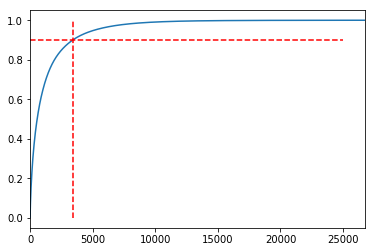

In [7]:
(
    count_movie_df
    .used_rating_ratio
    .reset_index(drop=True)
    .plot()
)
plt.plot([3400,3400],[0, 1.0], 'r--')
plt.plot([0,25000],[0.9, 0.9], 'r--')
plt.show()

영화별 평점 데이터를 평점이 많은 순으로 합쳤을 때, 전체 평점 데이터의 90%쯤 되는 지점의 영화가 가지는 최소 별점 갯수를 알아보겠습니다.

In [8]:
min_threshold = (
    count_movie_df
    [count_movie_df.used_rating_ratio<0.9]
    .movie_count
    .min()
)
print(f"영화의 최소 평가 수 : {min_threshold}번")

영화의 최소 평가 수 : 879번


최소한 879개의 평점을 받은 영화를 남기고, 나머지를 제거해야 하는 것으로 나옵니다.

In [9]:
used_movie = (
    count_movie_df
    [count_movie_df.used_rating_ratio<0.9]
    .index
)
print(f"해당하는 영화 수 : {len(used_movie)}개")

해당하는 영화 수 : 3410개


이 기준에 부합하는 영화는 3410개정도 됩니다.

In [10]:
truncated_rating_df = (
    rating_df[rating_df.movie_id.isin(used_movie)])

print(f"추리기 전 별점 데이터 수 : {len(rating_df)}개")
print(f"추린 후 별점 데이터 수 : {len(truncated_rating_df)}개")

추리기 전 별점 데이터 수 : 20000263개
추린 후 별점 데이터 수 : 17999984개


영화를 추리고 나니, 별점 데이터가 1,799만개 정도 남았습니다.

## 3. 유저 최소 기준 선정하기
이번에는 동일한 방법으로 유사도 계산에 사용할 유저를 정할 최소 기준을 정해봅시다.

In [11]:
# user id 별 rating의 개수를 계산하고, 크기순 정렬
count_per_user = (
    truncated_rating_df  # 위에서 추려진 별점 테이블에서
    .user_id  # 유저 아이디가
    .value_counts()  # 각각 몇번씩 있었는지 계산하고,
    .sort_values(ascending=False)  # 이를 내림차순으로 정렬하세요
)
count_per_user.head()

8405      3153
118205    2976
74142     2743
34576     2608
125794    2606
Name: user_id, dtype: int64

In [12]:
used_rating_ratio_per_count = (
    count_per_user.cumsum() # 누적합 계산
    / len(truncated_rating_df) # 전체 카운트 수 나눔
)

In [13]:
count_user_df = pd.concat(
    [count_per_user, used_rating_ratio_per_count], axis=1)
count_user_df.columns = ["user_count", "used_rating_ratio"]
count_user_df.head()

,user_count,used_rating_ratio
8405,3153,0.000175
118205,2976,0.000341
74142,2743,0.000493
34576,2608,0.000638
125794,2606,0.000783


유저도 전체 리뷰 정보의 90%를 포괄하는 수준으로 수를 제한하도록 하겠습니다.

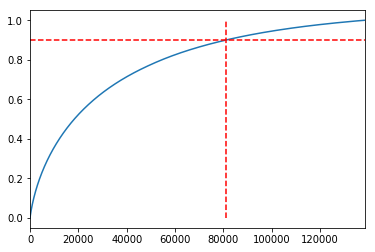

In [14]:
(
    count_user_df
    .used_rating_ratio
    .reset_index(drop=True)
    .plot()
)
plt.plot([81000,81000],[0, 1.0], 'r--')
plt.plot([0,150000],[0.9, 0.9], 'r--')
plt.show()

영화보다 누적 리뷰수 그래프가 완만하게 올라갑니다. 영화는 일부 영화에 평점 데이터가 많이 쏠려 있는 반면, 유저별 평점 데이터 수는 보다 고르게 분포한 것을 알 수 있습니다.

In [15]:
min_threshold = (
    count_user_df
    [count_user_df.used_rating_ratio<0.9]
    .user_count
    .min()
)
print(f"최소 유저의 평가 수 : {min_threshold}")

최소 유저의 평가 수 : 51


최소 51개의 리뷰를 남긴 유저를 남겨야 하는 것으로 나왔습니다.

In [16]:
used_user = (
    count_user_df
    [count_user_df.used_rating_ratio<0.9]
    .index
)
print(f"해당하는 유저 수 : {len(used_user)}")

해당하는 유저 수 : 81073


이 기준에 부합하는 유저는 총 81,073명입니다.

In [17]:
truncated_rating_df = truncated_rating_df[
    truncated_rating_df.user_id.isin(used_user)]

print(f"추리기 전 별점 데이터 수 : {len(rating_df)}개")
print(f"추린 후 별점 데이터 수 : {len(truncated_rating_df)}개")

추리기 전 별점 데이터 수 : 20000263개
추린 후 별점 데이터 수 : 16199943개


유저를 기준으로 추리고 나니 별점 데이터가 1,620만개 정도 남았습니다.

## 4. User-Item Matrix 만들기

리뷰 데이터의 정보를 최대한 유지하면서도, 유저-아이템 행렬의 희소성 문제를 줄일 수 있도록 유저와 영화를 적정 수준에서 걸러낸 `truncated_rating_df`를 만들었습니다. 이를 활용해 유저-아이템 행렬을 만들어봅시다. 데이터가 커서 만들어지는 데 다소 시간이 걸릴 수 있습니다.

In [18]:
ui_df = (
    truncated_rating_df
    .pivot_table(
        values='rating',
        index='user_id',
        columns='movie_id'))

이전 시간에서 다루었듯이 유사도를 계산하기 위해 영화의 편향과 유저의 편향을 제거하도록 하겠습니다.

In [19]:
avg_rating = np.mean(ui_df)

# 고객의 편향 계산하기
user_bias = ui_df.mean(axis=1) - avg_rating
# 아이템의 편향 계산하기
item_bias = ui_df.mean(axis=0) - avg_rating

adjusted_ui_df = (
    ui_df  # 유저 / 아이템 행렬에서
    .sub(user_bias,'rows') # 유저 편향을 제거하고
    .sub(item_bias,'columns') # 아이템 편향을 제거하여 보정하자
)

그리고 결측값(`np.nan`으로 입력되어 있음)을 0으로 채워주도록 합니다. 이러한 결측치(Missing Value)를 어떻게 채워주어야 하는가는 매우 중요한 문제이고, 값을 잘못 채울 경우에는 큰 성능 저하가 생기기도 합니다. 지금은 가장 간단한 방식인 0으로 채우는 방식으로 진행합니다.

In [20]:
adjusted_ui_df = adjusted_ui_df.fillna(0)

## 5. 코사인 유사도를 활용하여 유사도 행렬 구성하기


앞서 배운 코사인 유사도 수식을 떠올려봅시다.
$$
Cosine\_Similarity(X,Y) = \frac{\sum_{i=1}^{n}x_i y_i}{\sqrt{\sum_{i=1}^{n}x_i^2} \sqrt{\sum_{i=1}^{n}y_i^2}}
$$

영화X와 영화Y의 코사인 유사도를 구한다고 하면, 각 영화에 대해 유저$1$부터 유저$n$번째 유저가 남긴 평점 벡터를 가져와 위의 연산을 수행해야 합니다. 이를 함수로 정의하면 아래와 같이 정의할 수 있을 것입니다. `calculate_cosine_similarity`의 입력값 `x`와 `y`는 각각 영화X와 영화Y에 대해 전체 유저가 남긴 평점 벡터입니다.

In [21]:
def calculate_cosine_similarity(x, y):
    return np.sum(x*y)/(np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)))

In [22]:
## For 구문으로 작성하기



### (1) 위의 코드를 개선하기 - `scikit-learn ` 모듈 이용하기

Scipy에서는 거리를 계산하는 것을 빠르게 해주는 코드들을 제공합니다.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

### (2) 위의 코드를 개선하기 - Vectorize 이용하기

하지만, 위와 같이 코드를 작성할 경우 행렬을 구성하는 데에 굉장히 오랜 시간이 소요됩니다.<br>
<br>
이를 보다 빠르게 하기 위해서는 numpy의 벡터 연산을 이용해 계산을 수행해야 합니다. 다시 코사인 유사도 수식을 조금 정리해봅시다. <br>
<br>
$$
Cosine\_Similarity(X,Y) = \frac{\sum_{i=1}^{n}x_i y_i}{\sqrt{\sum_{i=1}^{n}x_i^2} \sqrt{\sum_{i=1}^{n}y_i^2}} =  \frac{X \cdot Y}{|X| |Y|}
$$
<br>
코사인 유사도에서 분자에 해당하는 $\sum_{i=1}^{n}x_i y_i$는 사실 행렬$X$와 행렬$Y$에 행렬곱을 수행하는 것과 같고, 각 행렬 원소의 제곱합에 루트를 씌우는 것은 각 행렬의 크기(노름)를 구하는 것과 같습니다. <br>
<br>
$$
Cosine\_Similarity(X,Y) =  \frac{X \cdot Y}{|X| |Y|} = \frac{X}{|X|}\cdot\frac{Y}{|Y|} = \hat X \cdot \hat Y
$$
<br>
또한 이는 각 벡터를 단위벡터화(정규화)한 후, 행렬곱을 적용하는 것과 동일합니다. 이렇게 수식을 정리하면 훨씬 더 빠르게 코사인 유사도를 계산할 수 있습니다.

행렬곱을 적용한 코사인 유사도 수식을 유저-아이템 행렬(`adjusted_ui_matrix`)에 적용하려면 어떻게 해야 할까요?<br>

![Imgur](https://i.imgur.com/e1Dpxnf.jpg)

아래와 같이 유저-아이템 행렬($R$)을 전치하여 만든 아이템-유저 행렬($R^{T}$) 를 각각 정규화한 후, 행렬곱을 수행해야 합니다($=\hat {R^T} \cdot \hat R$) <br>
혹은 유저-아이템 행렬($R$)을 정규화한 후 전치하여, 행렬곱을 수행해야 합니다($={\hat R}^T \cdot \hat R$) 
<br>
$$
Cosine\_Similarity(R^T,R) =  \frac{R^T \cdot R}{|R^T| |R|} = \frac{R^T}{|R^T|}\cdot\frac{R}{|R|} = \hat {R^T} \cdot \hat R = {\hat R}^T \cdot \hat R
$$
<br>

#### 1. 정규화하기

#### 2. 행렬곱연산 수행하기 

행렬곱을 이용하지 않았을 때에는 대략 1시간 정도 걸리는데, 행렬곱 연산을 이용하면 12.5초에 끝납니다. 대략 200배에서 300배 정도 빠르게 연산이 가능합니다.

CPU times: user 34.5 s, sys: 2.56 s, total: 37 s
Wall time: 12.7 s


#### 3. 대각행렬을 0으로 채우기

대각행렬은 자기 자신과의 유사도를 계산하는 것이기 때문에 항상 1로 나옵니다. 이럴 경우, 자기 자신을 추천하는 문제가 발생할 수 있어 자기 자신에 대해서는 유사도를 0으로 바꾸어 주었습니다.

#### 4. id를 title로 변경하기

movie_id는 우리가 읽기가 어렵기 때문에, movie_title로 변경해주도록 하겠습니다.

In [30]:
movie_ids = ui_df.columns
id2title = dict(zip(movie_df.id,movie_df.title))
movie_titles = [id2title[i] for i in movie_ids]

cosine_similarity_df = pd.DataFrame(
    cosine_similarity, 
    index=movie_titles, 
    columns=movie_titles)

In [31]:
cosine_similarity_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,0.000000,0.465921,0.335888,0.147964,0.324584,0.417938,0.306423,0.132104,0.177190,0.438620,...,0.134951,0.142281,0.121270,0.117425,0.130039,0.133574,0.122806,0.101267,0.094809,0.145492
Jumanji,0.465921,0.000000,0.303601,0.126080,0.346444,0.337574,0.271782,0.191040,0.159935,0.483497,...,0.088708,0.128828,0.081833,0.105101,0.118618,0.131205,0.104206,0.075101,0.071241,0.104333
Grumpier Old Men,0.335888,0.303601,0.000000,0.139308,0.470363,0.285895,0.350633,0.146572,0.246230,0.292165,...,0.025235,0.045153,0.005565,0.031561,0.050028,0.037892,0.049162,0.000000,0.015351,0.040659
Waiting to Exhale,0.147964,0.126080,0.139308,0.000000,0.195819,0.151300,0.258574,0.145244,0.181910,0.121212,...,0.000000,0.002523,0.002376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Father of the Bride Part II,0.324584,0.346444,0.470363,0.195819,0.000000,0.237949,0.412648,0.173731,0.225173,0.281235,...,0.019357,0.050466,0.021864,0.056065,0.054027,0.058747,0.064432,0.014899,0.044127,0.051452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.133574,0.131205,0.037892,0.000000,0.058747,0.105438,0.035436,0.025498,0.000000,0.065668,...,0.482568,0.471213,0.436840,0.463290,0.661168,0.000000,0.659557,0.330929,0.442929,0.650735
Edge of Tomorrow,0.122806,0.104206,0.049162,0.000000,0.064432,0.112981,0.012326,0.026324,0.000000,0.062470,...,0.389150,0.384760,0.409984,0.554657,0.540743,0.659557,0.000000,0.351345,0.431077,0.656674
Boyhood,0.101267,0.075101,0.000000,0.000000,0.014899,0.072934,0.020636,0.000000,0.000000,0.046684,...,0.487251,0.255542,0.465908,0.420756,0.266164,0.330929,0.351345,0.000000,0.420677,0.452564
Gone Girl,0.094809,0.071241,0.015351,0.000000,0.044127,0.101207,0.034894,0.000000,0.017570,0.029162,...,0.440629,0.257935,0.439327,0.581270,0.271270,0.442929,0.431077,0.420677,0.000000,0.385920


## 6. 유사도 행렬을 바탕으로 유사 제품 추천하기

이제 코사인 유사도로 채워진 유사도 행렬이 완성되었습니다. 유사도 행렬을 이용해서 어떤 영화를 보았다고 할 때, 어떤 영화를 추천하는지 봅시다.

#### 토이스토리와 유사한 영화

In [32]:
(
    cosine_similarity_df
    .loc['Toy Story']
    .sort_values(ascending=False)
    .iloc[:5]
)

Forrest Gump                                  0.647886
Star Wars: Episode IV - A New Hope            0.640314
Star Wars: Episode VI - Return of the Jedi    0.626862
Lion King, The                                0.626330
Toy Story 2                                   0.626258
Name: Toy Story, dtype: float64

#### 스타워즈와 유사한 영화

In [33]:
(
    cosine_similarity_df
    .loc['Star Wars: Episode IV - A New Hope']
    .sort_values(ascending=False)
    .iloc[:5]
)

Star Wars: Episode V - The Empire Strikes Back                             0.851311
Star Wars: Episode VI - Return of the Jedi                                 0.841000
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)    0.743605
Back to the Future                                                         0.689994
Indiana Jones and the Last Crusade                                         0.689198
Name: Star Wars: Episode IV - A New Hope, dtype: float64

#### 쏘우와 유사한 영화

In [34]:
(
    cosine_similarity_df
    .loc['Saw']
    .sort_values(ascending=False)
    .iloc[:5]
)

Saw II                  0.557432
The Butterfly Effect    0.463747
Saw III                 0.444083
Identity                0.424483
I, Robot                0.419320
Name: Saw, dtype: float64

#### 링와 유사한 영화

In [35]:
(
    cosine_similarity_df
    .loc['Ring, The']
    .sort_values(ascending=False)
    .iloc[:5]
)

Others, The       0.514384
Signs             0.505377
Identity          0.490836
28 Days Later     0.482338
Bruce Almighty    0.478180
Name: Ring, The, dtype: float64

# \[  더 나아가기 \]
---



## 1. 유클리디안 유사도 수식을 통해 유사도 행렬 구성하기

앞서 코사인 유사도를 이용해 유사도 행렬을 구하고, 영화를 추천하는 시스템을 구현해보았습니다. 이번에는 코사인 유사도 대신 유클리디안 유사도를 써봅시다.


$$
distance(X,Y) = \sqrt{\sum(X_i - Y_i)^2} = \sqrt{\sum(X_i^2 + Y_i^2 - 2X_iY_i)} = \sqrt{\sum X_i^2 + \sum Y_i^2 - 2 X \cdot Y}
$$

이번에도 코사인 유사도 때와 같이 벡터 연산을 이용해 풀도록 하겠습니다. For 구문으로 작성할 경우 시간이 오랫동안 소요됩니다.

### (1) 제곱 값 계산하기  ($\sum X_i^2$,   $\sum Y_i^2$)

### (2) Dot 연산 계산하기

### (3) 유클리디안 거리 구하기

### (4) 유클리디안 유사도 계산하기

### (5) 유클리디안 유사도 행렬 구성하기

## 2. 유사도 행렬을 통해 유사 제품 추천하기
코사인 유사도를 이용한 추천 시스템과 어떤 차이가 있을까요? 코사인 유사도를 사용한 시스템에서는 비슷하면서도 다양한 영화가 추천된 반면, 유클리디안 거리 유사도를 이용한 추천 시스템에서는 각 시리즈의 후속작이 추천되는 결과가 나왔습니다. 시리즈물과 같이 매우 유사한 것을 추천하기 위해서는 유클리디안 거리 유사도가 좀 더 유용하고, 좀 더 다양한 영화를 추천하기 위해서는 코사인 유사도가 더 적합할 것입니다.

#### 토이스토리와 유사한 영화

In [ ]:
(
    euclidean_similarity_df
    .loc["Toy Story"]
    .sort_values(ascending=False)
    .iloc[:5]
)

#### 스타워즈와 유사한 영화

In [ ]:
(
    euclidean_similarity_df
    .loc['Star Wars: Episode IV - A New Hope']
    .sort_values(ascending=False)
    .iloc[:5]
)

#### 쏘우와 유사한 영화

In [ ]:
(
    euclidean_similarity_df
    .loc["Saw"]
    .sort_values(ascending=False)
    .iloc[:5]
)

#### 링와 유사한 영화

In [ ]:
(
    euclidean_similarity_df
    .loc['Ring, The']
    .sort_values(ascending=False)
    .iloc[:5]
)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2020/01/13


---